The above header is for creating a nicely-formatted `.html` and `.pdf` documents using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html` and `.pdf` versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-29.ipynb 

Other useful information about this notebook:

- Filename: `dissipation-theory--Study-29.ipynb`
- Continued from: `dissipation-theory--Study-28.ipynb`
- Continued to: ---

# Preliminaries

In [1]:
import numpy as np
import pandas

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import cycler

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
THIS = 'dissipation-theory--Study-29--'
fig = {}

In [4]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation4 import CantileverModel, SampleModel1, SampleModel2
from dissipationtheory.dissipation4 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation4 import theta1norm, gamma_perpendicular
from dissipationtheory.dissipation4 import theta1norm_jit, gamma_perpendicular_jit
from dissipationtheory.dissipation4 import blds_perpendicular, blds_perpendicular_jit
from dissipationtheory.dissipation4 import gamma_perpendicular_approx, BLDSzerohigh, BLDSzerolow, BLDSapproxK2

# Set up cantilever

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(75, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(35, 'nm'), 
    d = ureg.Quantity(38, 'nm'),
    z_c = ureg.Quantity(73, 'nm')
)

In [6]:
cantilever.args()

{'f_c': 75000.0,
 'k_c': 2.8,
 'V_ts': 1,
 'R': 3.5e-08,
 'd': 3.8e-08,
 'z_c': 7.3e-08}

# Low dielectric constant, thick sample

Make the dielectric constant low, and make the sample thickness $100$ times the charge-sample separation.

In [7]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(7300, 'nm'), # <== edit this 500 to 7300, 100 times the sample-charge separation
    epsilon_s = ureg.Quantity(complex(3, -0.2), ''),  # <== edit this 3->30
    sigma = ureg.Quantity(1E-5, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(300, 'nm')
)

In [8]:
sample1.args()

{'cantilever': <numba.experimental.jitclass.boxing.CantileverModelJit at 0x1254dc7c0>,
 'h_s': 7.3e-06,
 'epsilon_s': (3-0.2j),
 'sigma': 1e-05,
 'rho': 1e+21,
 'epsilon_d': (1000000+0j),
 'z_r': 3.0000000000000004e-07}

In [9]:
sample1_jit = SampleModel1Jit(**sample1.args())
sample1_jit.print()

cantilever
        cantilever freq =  75000.0 Hz
                        =  471238.89803846896 rad/s
        spring constant =  2.8 N/m
     tip-sample voltage =  1.0 V
                 radius =  3.5e-08 m
                 height =  3.8e-08 m
  tip charge z location =  7.3e-08 m

semiconductor
          epsilon (real) =  3.0
          epsilon (imag) =  -0.2
               thickness =  7.3e-06 m
            conductivity =  1e-05 S/m
          charge density =  1e+21 m^{{-3}}
        reference height =  3.0000000000000004e-07 m
 
      roll-off frequency =  1129409.0673730192 Hz
                mobility =  6.241509090043337e-08 m^2/(V s)
      diffusion constant =  1.6135549206567651e-09 m^2/s
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  5.851555252782804e-08 m
effective epsilon (real) =  3.0
effective epsilon (imag) =  -2.5966804779363124

dielectric
 epsilon (real) =  1000000.0
 epsilon (imag) =  0.0
      thickness = infinite


# Example friction calculation

Spot-check the new friction-calculation code by comparing a numba/jit result to a pure-Python result.

First, the numba/jit result.

In [10]:
%%time
ans1a = gamma_perpendicular_jit(theta1norm_jit, sample1_jit)
ans1a

CPU times: user 11.4 ms, sys: 600 µs, total: 12 ms
Wall time: 12 ms


Magnitude,[15.636682621164582 6.620727848134976 1.4106662825740859]
Units,piconewton second/meter


Now the pure Python result.

In [11]:
%%time
ans1b = gamma_perpendicular(theta1norm, sample1)
ans1b

CPU times: user 2.66 s, sys: 30.4 ms, total: 2.69 s
Wall time: 2.81 s


Magnitude,[15.636682621164585 6.620727848134971 1.410666282574083]
Units,piconewton second/meter


By inspection we get the same result for the three terms' contribution to the friction.  Success!

The numba/jit calculation is 100 to 200 times faster.  

The friction is smaller here than in `Study 28` because the tip charge is further away now, located not at $d$ but at $z_\text{c} = d + R$.

# Example BLDS calculation

Compare the execution time for pure-Python and numba/jit calculations.

In [12]:
omega_m = ureg.Quantity(2 * np.pi * np.logspace(1, 2, 2), 'Hz')

In [13]:
%%time
ans2a = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m)
ans2a 

CPU times: user 20.2 ms, sys: 662 µs, total: 20.9 ms
Wall time: 21.4 ms


Magnitude,[[-0.46837402414292395 -0.14648224632130472 -0.4085291843706752] [-0.4683766165281598 -0.14648318667137 -0.4085247945951709]]
Units,hertz


In [14]:
%%time
ans2b = blds_perpendicular(theta1norm, sample1, omega_m)
ans2b 

CPU times: user 6.01 s, sys: 74.8 ms, total: 6.09 s
Wall time: 6.24 s


Magnitude,[[-0.4683740241429243 -0.14648224632130466 -0.4085291843706754] [-0.4683766165281601 -0.1464831866713699 -0.40852479459517127]]
Units,hertz


By inspection we get the same result for the two terms' contribution to the BDLS frequency shift. The numba/jit calculation is 150 to 200 times faster.

The BLDS frequency shift is smaller here than in `Study 28` because the tip charge is further away now, located not at $d$ but at $z_\text{c} = d + R$.

## Representative BLDS spectrum calculation

I am echoing the code from `Study 28` here.  Set up an array of modulation frequencies and an array of charge densities.

In [15]:
N_omega = 100
N_sigma = 50

In [16]:
omega_m = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=N_omega), 'Hz')

In [17]:
sigma = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-10),
        stop=np.log10(1),
        num=N_sigma), 'S/m')

Assume a fixed mobility of $\mu = 10^{-8} \: \mathrm{m}^2/\mathrm{V s}$, an ionic mobility.  As we vary $\sigma$, we should vary the charge density $\rho$ to keep the mobility constant.

In [18]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)') 
rho = (sigma / (qe * mu)).to('1/m^3')

Get ready to run the simulations.

In [19]:
data = {}        # many simulations
data['01'] = {}  # the first simulation

Loop over conductivities, computing the BLDS spectrum and the friction.

In [20]:
def calculate(sample1_jit, rho, sigma):
    
    data = {}
    for rho_, sigma_ in zip(rho, sigma):

        sample1_jit.rho = rho_.to('1/m^3').magnitude
        sample1_jit.sigma = sigma_.to('S/m').magnitude
    
        gamma = gamma_perpendicular_jit(theta1norm_jit, sample1_jit).to('pN s/m')
        f_BLDS = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_m).to('Hz')
        
        data[str(sigma_.to('S/m').magnitude)] = {
            'omega_m': omega_m,
            'f_BLDS': f_BLDS, 
            'gamma': gamma,
            'sigma': ureg.Quantity(sample1_jit.sigma, 'S/m'),
            'h': ureg.Quantity(sample1_jit.cantilever.z_c, 'm'),  # change from cantilever.d to cantilever.z_c
            'rho': ureg.Quantity(sample1_jit.rho, '1/m^3'),
            'LD': ureg.Quantity(sample1_jit.LD, 'm'),
            'omega_c': ureg.Quantity(sample1_jit.cantilever.omega_c, 'Hz'),
            'omega_0': (ureg.Quantity(sample1_jit.sigma, 'S/m')/epsilon0).to('Hz')}

    return data

In [21]:
%%time

data['01'] = calculate(sample1_jit, rho, sigma)

CPU times: user 12.7 s, sys: 152 ms, total: 12.9 s
Wall time: 13.1 s


A helper plotting function.

In [22]:
def plotBLDS(data):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['omega_m'].to('Hz').magnitude,
                np.abs(data[key]['f_BLDS'].sum(axis=1).to('Hz').magnitude),
                '-',
                color=color_list[index])

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. freq. $\omega_{\mathrm{m}}$ [rad/s]')
    plt.tight_layout()
    plt.show()
    
    return fig

Plot every 3rd BLDS spectrum.

In [23]:
data['01-short'] = {}
for key in list(data['01'].keys())[::3]:
    data['01-short'][key] = data['01'][key]

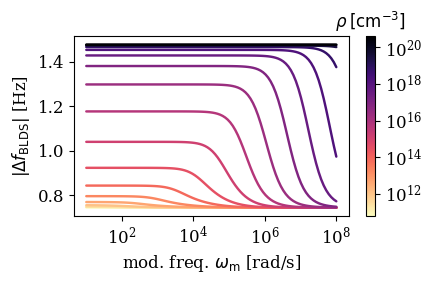

In [24]:
#| label: fig-blds
#| fig-cap: "Broadband local dielectric spectrum of a semi-infinite semiconductor versus charge density."

fig['01'] = plotBLDS(data['01-short'])

Convert the data dictionary to a pandas dataframe.  We want to exract the data in the rows, as numbers without units, for plotting.  Loop over each row in the dataframe, converting each row to a numpy array.  For each row, loop over the elements of the array, specify the element's units, and get the magnitude of the resulting element.  Convert the result list to a numpy array. 

In [25]:
def plotme(data, sample):

    df = pandas.DataFrame.from_dict(data)

    keys =  ['omega_m', 'f_BLDS', 'gamma',  'sigma', 'h', 'rho',   'LD', 'omega_c', 'omega_0']
    units = ['Hz',      'Hz',     'pN s/m', 'S/m',   'm', '1/m^3', 'm',  'Hz',      'Hz']

    adict = {}
    for key, unit in zip(keys, units):
        adict[key] = np.array([a.to(unit).magnitude for a in df.loc[key].to_numpy()])

    # (Left hand plot) 
    # Make the x-axis the unitless ratio of the height to Debye length squared,
    # which is proportional to charge density.

    xL = (adict['h']/adict['LD'])**2
    rho0L = (adict['rho']/xL)[0]
    
    # Define functions to convert from xL to rho and back again
    
    def fwdL(xL):
        return xL*rho0L

    def revL(rho):
        return rho/rho0L

    # (Right hand plot)
    # Make the x-axis the unitless ratio of omega_0 to omega_c, which
    # is proportional to conductivity and therefore charge density

    xR = adict['omega_0']/(sample.epsilon_s.real.magnitude * adict['omega_c'])
    rho0R = (adict['rho']/xR)[0]
    
    # Define functions to convert from xR to rho and back again

    def fwdR(xR):
        return xR*rho0R

    def revR(rho):
        return rho/rho0R
    
    # Now make the nice plot
    
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 5))
    
    ax2L = ax[0].secondary_xaxis("top", functions=(fwdL,revL))
    ax2R = ax[1].secondary_xaxis("top", functions=(fwdR,revR))

    # xL_sub, BLDS_sub = BLDSapprox(sample, xL)
    
    with plt.style.context('seaborn-v0_8'):

        # get current color cycle
        
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        color_cycle = cycler.cycler('color', colors[0:3])
        ax[0].set_prop_cycle(color_cycle)
        ax[1].set_prop_cycle(color_cycle)
        
        # approximation for zero-freq BLDS, K2 term
        
        x_sub, BLDSapprox = BLDSapproxK2(sample, xL)
        ax[0].semilogx(
            x_sub,
            BLDSapprox,
            ':',
            color=colors[0],
            label=['$K_2$ approx.'])

        # exact calculations
        
        ax[0].semilogx(
            xL,
            adict['f_BLDS'][:,0,:], 
            '-',
            label=['$K_2$','$K_1$','$K_0$'])
        
        ax[1].loglog(
            xR,
            adict['gamma'], 
            '-',
            label=['$K_2$','$K_1$','$K_0$'])
        
        # limiting cases
        
        nL_part = int(2*len(xL)/3)
        
        ax[0].semilogx(
            xL[0:nL_part],
            BLDSzerolow(sample, xL)[0:nL_part,:], 
            '--')
        
        ax[0].semilogx(
            xL[-nL_part:-1],
            BLDSzerohigh(sample, xL)[-nL_part:-1,:],
            '-.')

        nR_part = int(len(xR)/2)

        g_low, g_approx = gamma_perpendicular_approx(sample, xR)

        ax[1].loglog(
            xR[0:nR_part],
            g_low[0:nR_part,:],
            '--')
        
        ax[1].loglog(
            xR[0:nR_part],
            g_approx[0:nR_part,:],
            ':',
            label=['$K_2$ approx','$K_1$ approx','$K_0$ approx'])

    ax[0].set_xlabel(r'$(h / \lambda_{\mathrm{D}})^2$')
    ax[0].set_ylabel(r'$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$ [Hz]')
    ax[0].legend(fontsize=9)
    ax[0].grid()
    ax[1].grid()
    
    ax[1].set_xlabel(r'$\omega_0/(\epsilon_{\mathrm{s}}^{\prime} \omega_{\mathrm{c}})$')
    ax[1].set_ylabel(r'$\gamma_{\perp}$ [pN s/m]')
    ax[1].legend(fontsize=9)
    ax[1].set_ylim(
        [0.95 * adict['gamma'].min(),
         1.05 * adict['gamma'].max()])
    
    ax2L.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    ax2R.set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.tight_layout()
    plt.show()
    
    return fig

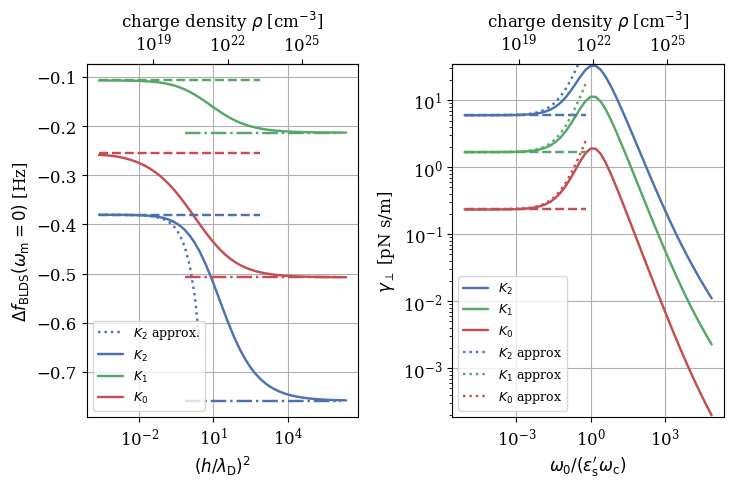

In [26]:
fig['02'] = plotme(data['01'], sample1)

Compared to `Study 28`, the BLDS frequency shift is smaller here by a factor of approximately 8 smaller.  This is a significant change.

In [27]:
def checklimits(data, sample):

    df = pandas.DataFrame.from_dict(data)

    keys =  ['omega_m', 'f_BLDS', 'gamma',  'sigma', 'h', 'rho',   'LD', 'omega_c', 'omega_0']
    units = ['Hz',      'Hz',     'pN s/m', 'S/m',   'm', '1/m^3', 'm',  'Hz',      'Hz']

    adict = {}
    for key, unit in zip(keys, units):
        adict[key] = np.array([a.to(unit).magnitude for a in df.loc[key].to_numpy()])

    xL = (adict['h']/adict['LD'])**2

    dg = pandas.DataFrame.from_dict(
        {'terms': ['K2','K1','K0'],
         'f_BLDS low [Hz]': adict['f_BLDS'][0,0,:],
         'Loring low [Hz]': BLDSzerolow(sample, 0.)[0],
         'f_BLDS high [Hz]': adict['f_BLDS'][-1,0,:],
         'Loring high [Hz]': BLDSzerohigh(sample, 0.)[0]}
    )

    print(dg)

In [28]:
checklimits(data['01'], sample1)

  terms  f_BLDS low [Hz]  Loring low [Hz]  f_BLDS high [Hz]  Loring high [Hz]
0    K2        -0.380333        -0.380311         -0.757871         -0.758730
1    K1        -0.106954        -0.106904         -0.213116         -0.213277
2    K0        -0.258413        -0.254393         -0.507329         -0.507520


In [29]:
sample1

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
                 height = 38.000 nm
  tip charge z location = 73.000 nm

semiconductor

             epsilon (real) = 3.000
             epsilon (imag) = -0.200
                  thickness = 7300.0 nm
               conductivity = 1.000e-05 S/m
             charge density = 1.000e+21 m^{-3}
           reference height = 3.000e+02 nm

         roll-off frequency = 1.129e+06 Hz
                   mobility = 6.242e-08 m^2/(V s)
         diffusion constant = 1.614e-09 m^2/s
               Debye length = 3.780e+01 nm
           diffusion length = 5.852e+01 nm
   effective epsilon (real) = 3.000
   effective epsilon (imag) = -2.597

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

# High dielectric-constant, thick sample

Change the sample dielectric constant from 3 to 30.

In [30]:
sample2 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(7300, 'nm'),
    epsilon_s = ureg.Quantity(complex(30, -0.2), ''),  # <== edit this 3->30
    sigma = ureg.Quantity(1E-5, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(300, 'nm')
)

In [31]:
sample2_jit = SampleModel1Jit(**sample2.args())

use the same `omega_m` and `sigma` as above.

In [32]:
data['02'] = calculate(sample2_jit, rho, sigma)

In [33]:
data['02-short'] = {}
for key in list(data['02'].keys())[::3]:
    data['02-short'][key] = data['02'][key]

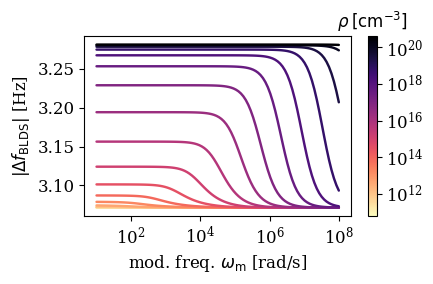

In [34]:
fig['03'] = plotBLDS(data['02-short'])

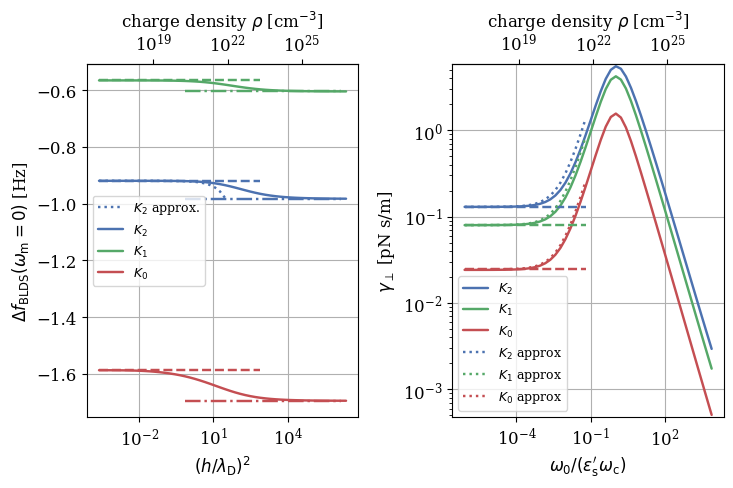

In [35]:
fig['04'] = plotme(data['02'], sample2)

In [36]:
checklimits(data['02'], sample2)

  terms  f_BLDS low [Hz]  Loring low [Hz]  f_BLDS high [Hz]  Loring high [Hz]
0    K2        -0.919302        -0.919302         -0.982346         -0.982699
1    K1        -0.565425        -0.565417         -0.604265         -0.604409
2    K0        -1.586810        -1.585281         -1.694403         -1.694606


In [37]:
sample2

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
                 height = 38.000 nm
  tip charge z location = 73.000 nm

semiconductor

             epsilon (real) = 30.000
             epsilon (imag) = -0.200
                  thickness = 7300.0 nm
               conductivity = 1.000e-05 S/m
             charge density = 1.000e+21 m^{-3}
           reference height = 3.000e+02 nm

         roll-off frequency = 1.129e+06 Hz
                   mobility = 6.242e-08 m^2/(V s)
         diffusion constant = 1.614e-09 m^2/s
               Debye length = 3.780e+01 nm
           diffusion length = 5.852e+01 nm
   effective epsilon (real) = 30.000
   effective epsilon (imag) = -2.597

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

# Low dielectric-constant, thin sample

Go back to a low dielectric constant.  Make the sample thickness $0.1$ times the charge-sample separation. 

In [58]:
sample3 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(7.3, 'nm'),  # <== edit this 7300 -> 7.3
    epsilon_s = ureg.Quantity(complex(3, -0.2), ''), # <== edit this 30 -> 3
    sigma = ureg.Quantity(1E-5, 'S/m'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    z_r = ureg.Quantity(300, 'nm')
)

In [59]:
sample3_jit = SampleModel1Jit(**sample3.args())

In [60]:
data['03'] = calculate(sample3_jit, rho, sigma)

In [61]:
data['03-short'] = {}
for key in list(data['03'].keys())[::3]:
    data['03-short'][key] = data['03'][key]

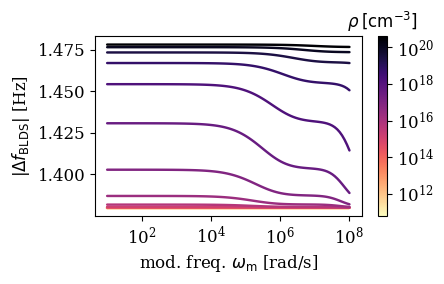

In [62]:
fig['05'] = plotBLDS(data['03-short'])

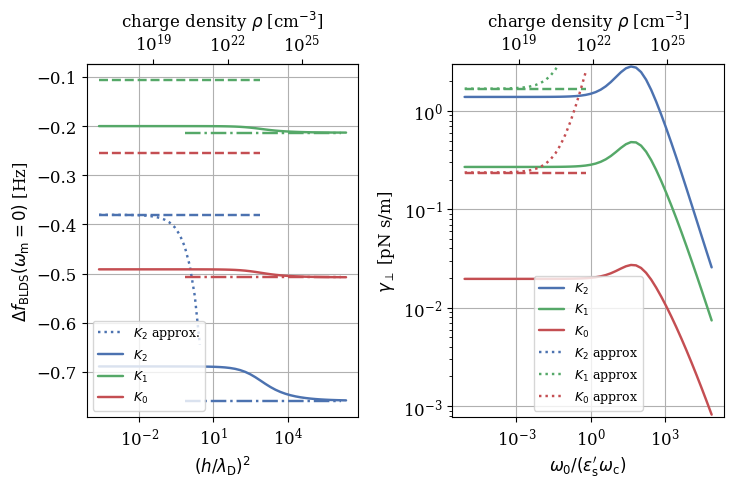

In [63]:
fig['06'] = plotme(data['03'], sample3)

In [64]:
checklimits(data['03'], sample3)

  terms  f_BLDS low [Hz]  Loring low [Hz]  f_BLDS high [Hz]  Loring high [Hz]
0    K2        -0.688819        -0.380311         -0.757871         -0.758730
1    K1        -0.199898        -0.106904         -0.213116         -0.213277
2    K0        -0.491281        -0.254393         -0.507329         -0.507520


In [65]:
sample3

cantilever

         resonance freq = 75.000 kHz
                        = 4.712e+05 rad/s
        spring constant = 2.800 N/m
     tip-sample voltage = 1.000 V
                 radius = 35.000 nm
                 height = 38.000 nm
  tip charge z location = 73.000 nm

semiconductor

             epsilon (real) = 3.000
             epsilon (imag) = -0.200
                  thickness = 7.3 nm
               conductivity = 1.000e-05 S/m
             charge density = 1.000e+21 m^{-3}
           reference height = 3.000e+02 nm

         roll-off frequency = 1.129e+06 Hz
                   mobility = 6.242e-08 m^2/(V s)
         diffusion constant = 1.614e-09 m^2/s
               Debye length = 3.780e+01 nm
           diffusion length = 5.852e+01 nm
   effective epsilon (real) = 3.000
   effective epsilon (imag) = -2.597

dielectric

  epsilon (real) = 1000000.000
  epsilon (imag) = 0.000
       thickness = infinite

# Save all figures

In [66]:
if 1:
    for num in fig.keys():
        figname = THIS + "Fig-" + num
        fig[num].savefig(figname + '.png', dpi=300)
        fig[num].savefig(figname + '.pdf')